### 【問題1】2次元畳み込み層の作成
### 【問題2】小さな配列での2次元畳み込み層の実験
### 【問題3】2次元畳み込み後の出力サイズ
### 【問題4】最大プーリング層の作成
### 【問題6】平滑化
### 【問題7】学習と推定

In [9]:
import numpy as np
from IPython.display import display
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

#
# Util
#
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング
    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """
    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad
    Returns
    -------
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 値を元に戻す
        it.iternext()

    return grad

class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

def pred_result(model, x_train, y_train, x_test, y_test):
    # 学習結果
    display(model.loss_train)

    # 予測
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)

    # 評価
    print("train accuracy_score: \t", accuracy_score(y_train, pred_train))
    print("train precision_score: \t", precision_score(y_train, pred_train, average="micro"))
    print("train recall_score: \t", recall_score(y_train, pred_train, average="micro"))
    print("train f1_score: \t", f1_score(y_train, pred_train, average="micro"))
    print("train accuracy_score: \t", accuracy_score(y_test, pred_test))
    print("train precision_score: \t", precision_score(y_test, pred_test, average="micro"))
    print("train recall_score: \t", recall_score(y_test, pred_test, average="micro"))
    print("train f1_score: \t", f1_score(y_test, pred_test, average="micro"))

    # lossグラフ
    plot_x = [i for i in range(1, model.epoch+1)]
    plt.plot(plot_x, model.loss_train, label='train')
    plt.plot(plot_x, model.loss_valid, label='valid')
    plt.legend()
    plt.show()

def filter_show(filters, nx=8, target=None, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        if target is not None and i != target:
            continue
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

#
# NN Layer
#
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        # 活性化関数は単純な判定なのでシンプル
        dout[self.mask] = 0
        dx = dout

        return dx

class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b

        self.x = None
        self.original_x_shape = None
        # 重み・バイアスパラメータの微分
        self.dW = None
        self.db = None

    def forward(self, x):
        # テンソル対応
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        dx = dx.reshape(*self.original_x_shape)  # 入力データの形状に戻す（テンソル対応）
        return dx

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

        # 中間データ（backward時に使用）
        self.x = None
        self.col = None
        self.col_W = None

        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        # print(f"x: {x.shape}") # 例:  (20, 30, 24, 24) size:345,600(86400 * 4)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        # データ総数: 345,600 を (86400, 4) に分解
        col = col.reshape(-1, self.pool_h*self.pool_w)
        # 列方向に最大値のindexを取って1次元配列として返す
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        # チャネル軸を後ろに。意味はわからない
        dout = dout.transpose(0, 2, 3, 1)
        # プーリング層のサイズ
        pool_size = self.pool_h * self.pool_w
        # サンプル数とプールサイズの2次元配列準備
        dmax = np.zeros((dout.size, pool_size)) # (86400, 4)

        # arg_shape: (86400,) dout_shape: (20, 12, 12, 30) dmax_shape: (86400, 4)
        # print(f"arg_shape: {self.arg_max.shape} dout_shape: {dout.shape} dmax_shape: {dmax.shape}")
        # print(f"arg_max: {self.arg_max[:100]}")
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()

        dmax = dmax.reshape(dout.shape + (pool_size,))

        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)

        return dx

from collections import OrderedDict

class SimpleConvNet:
    """単純なConvNet
    conv - relu - pool - affine - relu - affine - softmax

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {
            'W1': weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size),
            'b1': np.zeros(filter_num),
            'W2': weight_init_std * np.random.randn(pool_output_size, hidden_size),
            'b2': np.zeros(hidden_size),
            'W3': weight_init_std * np.random.randn(hidden_size, output_size),
            'b3': np.zeros(output_size)
        }

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {
            'W1': self.layers['Conv1'].dW,
            'b1': self.layers['Conv1'].db,
            'W2': self.layers['Affine1'].dW,
            'b2': self.layers['Affine1'].db,
            'W3': self.layers['Affine2'].dW,
            'b3': self.layers['Affine2'].db
        }

        return grads

epoch: 1 ===================


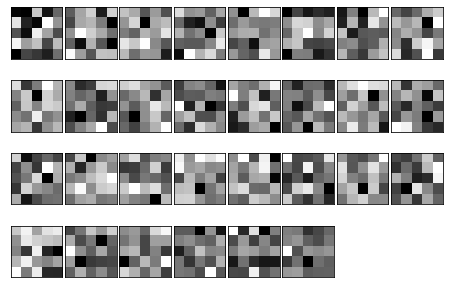

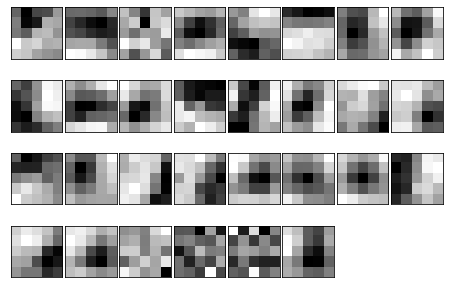

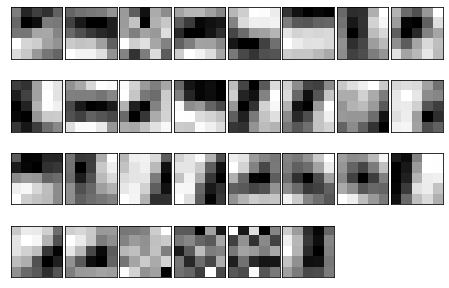

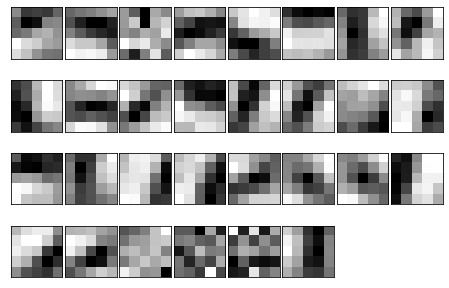

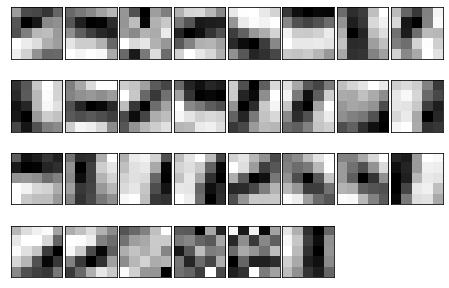

0.0028262084551393604
epoch: 2 ===================


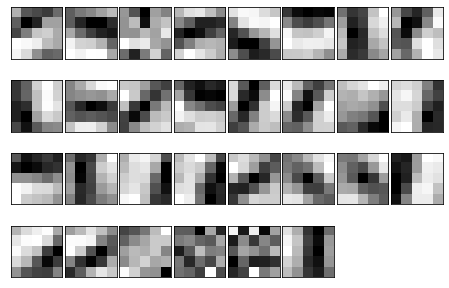

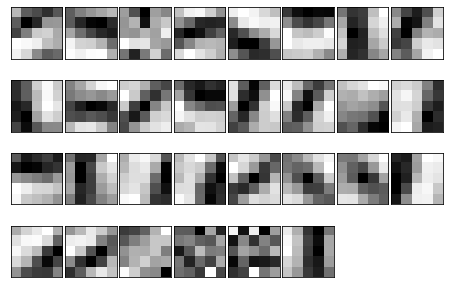

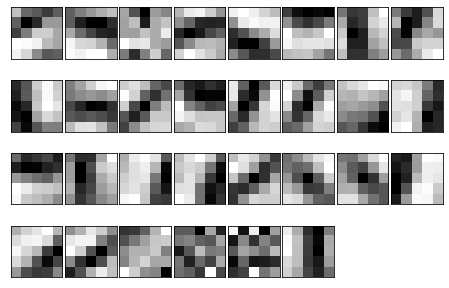

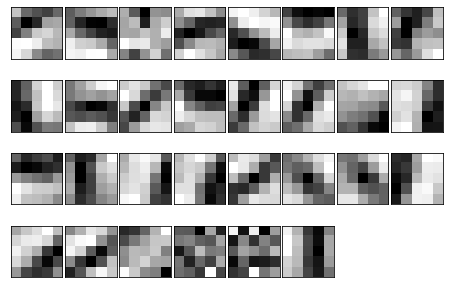

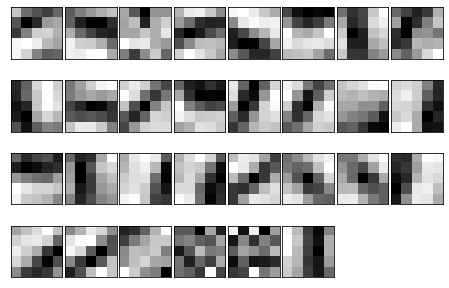

0.0008673135681133275


In [10]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data() # shape(60000, 28, 28)
# スケール調整
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
# 行数削減
# x_train = x_train[:40]
# y_train_one_hot = y_train_one_hot[:40]
# チャネルを追加 (外側にチャネル用の配列を追加し、レコード数と軸を入れ替える)
x_train = np.array([x_train]).transpose((1, 0, 2, 3))
x_test = np.array([x_test]).transpose((1, 0, 2, 3))

net = SimpleConvNet()
learning_rate = 0.1
batch_size = 20
epoch = 2

mini_batch = GetMiniBatch(x_train, y_train_one_hot, batch_size=batch_size)
for i in range(epoch):
    print(f"epoch: {i+1} ===================")
    for i, (x_mini, y_mini) in enumerate(mini_batch):
        grad = net.gradient(x_mini, y_mini)
        for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
            net.params[key] -= learning_rate * grad[key]
        if i % 600 == 0:
            filter_show(net.params['W1'], target=None)
    print(net.loss(x_train[:20], y_train[:20]))

In [12]:
pred_train = net.predict(x_train[:3000])
pred_test = net.predict(x_test[:3000])
flt_pred_train = np.argmax(pred_train, axis=1)
flt_pred_test = np.argmax(pred_test, axis=1)
print("train:", accuracy_score(y_train[:3000], flt_pred_train))
print("test:", accuracy_score(y_test[:3000], flt_pred_test))




train: 0.988
test: 0.9796666666666667


### 【問題10】出力サイズとパラメータ数の計算

```
計算式: フィルター縦 * フィルター横 * 入力チャンネル数 * 出力チャンネル数 + バイアス(1チャネルごとに1つ)

1.
入力サイズ : 144×144, 3チャンネル
フィルタサイズ : 3×3, 6チャンネル
ストライド : 1
パディング : なし

パラメタ数: 3 * 3 * 3 * 6 + 6 = 168
出力サイズ: 6 * 142 * 142 ( チャネル数 * (144-(3-1)) * (144-(3-1)) )

2.
入力サイズ : 60×60, 24チャンネル
フィルタサイズ : 3×3, 48チャンネル
ストライド　: 1
パディング : なし

パラメタ数: 3 * 3 * 24 * 48 + 48 = 10416
出力サイズ: 48 * 58 * 58

3.
入力サイズ : 20×20, 10チャンネル
フィルタサイズ: 3×3, 20チャンネル
ストライド : 2
パディング : なし

パラメタ数: 3 * 3 * 10 * 20 + 20 = 1820
出力サイズ: 20 * 9 * 9 ( チャネル数 * ((20-(3-1))/2)) * ((20-(3-1))/2)) )
```